## Transfer Learning : Fine Tuning 


In [42]:
# Initiating GPU
import tensorflow as tf
import keras
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("CUDA Support:", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))


CUDA Support: True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
## Use for the helper script
from helper import *
import datetime
from helper import create_tensorboard_callback

import os

2025-02-15 17:52:18.934754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739638338.995434  116511 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739638339.013687  116511 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-15 17:52:19.140538: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Getting the data 10% 
walk_through_dir('10_food_classes_10_percent/10_food_classes_10_percent')


There are 2 directories and 0 images in '10_food_classes_10_percent/10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/10_food_classes_10_percent/test/steak'.
There are

In [3]:
# creating directories

train_dir = '10_food_classes_10_percent/10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/10_food_classes_10_percent/test'

- Using models pretrained from tf.keras.applications
---
Not using the image Generator for preprocessing td.data.Dataset


In [4]:
import tensorflow as tf

IMG_SIZE = (224 , 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode= "categorical",
                                                                            batch_size = BATCH_SIZE,
                                                                        )


test_data = tf.keras.preprocessing.image_dataset_from_directory(directory= test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                 )


Found 750 files belonging to 10 classes.


I0000 00:00:1739638344.061099  116511 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3965 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 2500 files belonging to 10 classes.


In [5]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [6]:
# Example of batch of data 

for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[0.00000000e+00 7.70408154e-01 2.00000000e+00]
   [0.00000000e+00 1.28571451e+00 2.33163261e+00]
   [0.00000000e+00 7.85714149e-01 4.00000000e+00]
   ...
   [0.00000000e+00 1.56123996e+00 4.56124020e+00]
   [3.31627905e-01 2.32651162e+00 3.32651162e+00]
   [3.62752891e+00 4.27038622e+00 6.27038622e+00]]

  [[9.28571701e-01 6.42857194e-01 5.96939027e-01]
   [6.63262978e-02 1.32652581e-01 6.63262978e-02]
   [0.00000000e+00 7.29591906e-01 5.40816188e-01]
   ...
   [2.39799738e-01 5.10187387e-01 1.91330910e+00]
   [0.00000000e+00 1.00001335e+00 1.98989391e-01]
   [2.18880844e+00 4.11738014e+00 3.11738014e+00]]

  [[1.56122434e+00 0.00000000e+00 0.00000000e+00]
   [1.12244450e-01 2.55102009e-01 0.00000000e+00]
   [2.51530719e+00 9.01530838e+00 2.15816474e+00]
   ...
   [2.46630077e+01 2.32344360e+01 1.96375141e+01]
   [7.51010180e+00 6.56623459e+00 4.70911789e+00]
   [3.67362112e-01 3.67362112e-01 7.65381381e-02]]

  ...

  [[7.85736084e-01 0.00000000e+00 2.00000000e+00]
   [0

2025-02-15 17:52:25.399123: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Sequential APIs Vs Functional APIs

- Building Another Feature Extraction model with "Keras Functional API" : Gives more Flexibility with models
- Inputs to the models are to be the same as the model was trained on : See Documentation for this 
---
### Average pool the outputs of the base model (aggregates all the most important weights : Reducing the number of computations)
---
*EfficientNet has Rescaling built in*

In [7]:
# Model 0 
import tf_keras
# Creating base model , with keras.application

base_model = tf_keras.applications.EfficientNetB0(include_top = False)


# Freezing the base model (underlying Weights are not changed)

base_model.trainable = False 

# Create inputs in the mdoel

inputs = tf_keras.layers.Input(shape = (224, 224 , 3), name = "input_layer")

# IF ResNet then the inputs need to be normalized 
# x = tf_keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Pass the inputs to the base model 

x = base_model(inputs)
print(f"Shape after passing inputs to base_model :{x.shape}")

# Average pool the outputs of the base model (aggregates all the most important weights : Reducing the number of computations)

x = tf_keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer") (x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# Output Activation Layer 

outputs = tf_keras.layers.Dense(10, activation= "softmax", name = "output_layer")(x)

# Combining inputs and outputs in a model 

model_0 = tf_keras.Model(inputs, outputs)





Shape after passing inputs to base_model :(None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


In [8]:
# Compiling the model 

model_0.compile(loss = 'categorical_crossentropy',
                optimizer = tf_keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [9]:
# Fitting 

from tf_keras.callbacks import TensorBoard

history_0 = model_0.fit(train_data_10_percent,
                             epochs=10,
                             steps_per_epoch=len(train_data_10_percent),
                             validation_data=test_data,
                             validation_steps=int(0.25 * len(test_data)),
                             callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                    experiment_name="10_percent_feature_extraction")])


Saving TensorBoard log files to: tensorflow_hub/10_percent_feature_extraction/20250215-175227
Epoch 1/10


I0000 00:00:1739638354.447482  117033 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1739638355.495571  117036 service.cc:148] XLA service 0x776cf49f1180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739638355.495668  117036 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-02-15 17:52:35.504229: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739638355.607312  117036 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 [==============================] - 12s 186ms/step - loss: 1.9011 - accuracy: 0.4027 - val_loss: 1.3269 - val_accuracy: 0.7286
Epoch 2/10
24/24 [==============================] - 2s 99ms/step - loss: 1.1167 - accuracy: 0.7573 - val_loss: 0.8834 - val_accuracy: 0.8141
Epoch 3/10
24/24 [==============================] - 2s 98ms/step - loss: 0.7878 - accuracy: 0.8253 - val_loss: 0.7085 - val_accuracy: 0.8487
Epoch 4/10
24/24 [==============================] - 2s 94ms/step - loss: 0.6475 - accuracy: 0.8613 - val_loss: 0.6160 - val_accuracy: 0.8602
Epoch 5/10
24/24 [==============================] - 2s 94ms/step - loss: 0.5607 - accuracy: 0.8867 - val_loss: 0.5694 - val_accuracy: 0.8618
Epoch 6/10
24/24 [==============================] - 2s 96ms/step - loss: 0.4793 - accuracy: 0.9067 - val_loss: 0.5233 - val_accuracy: 0.8668
Epoch 7/10
24/24 [==============================] - 2s 96ms/step - loss: 0.4256 - accuracy: 0.9080 - val_loss: 0.5088 - val_accuracy: 0.8651
Epoch 8/10
24/24 [====

In [10]:
# Evaluation of Full Dataset

model_0.evaluate(test_data)

79/79 [==============================] - 5s 58ms/step - loss: 0.4389 - accuracy: 0.8760


[0.4388715922832489, 0.8759999871253967]

In [11]:
# Checking the layers in the base_model 

for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.multiply
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activat

In [12]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

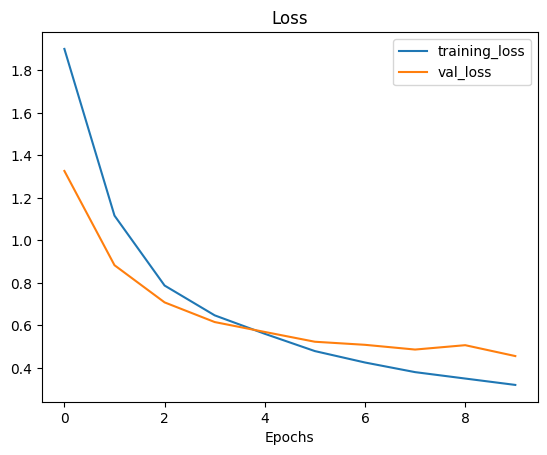

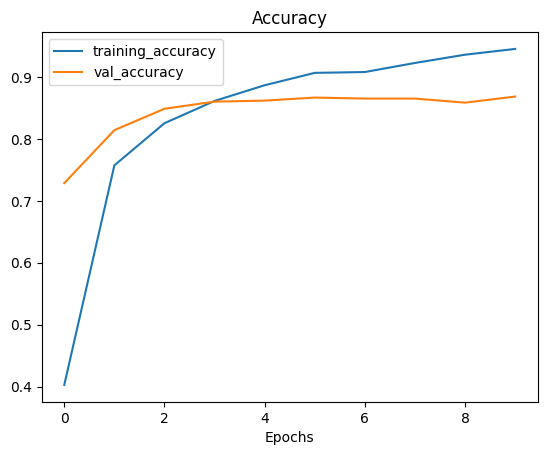

In [13]:
plot_loss_curves(history_0)

### Feature Vectors : Global Average Pooling 2D Layer :

##### Its the learned representation of input data ( compressed from from the POV of the moddel )

- If a tensor after passing through the base model has shape (None , 7 ,7 1280)
- When it passes through GlobalAveragePooling2D it becomes (None, 1280)
- Testing with similar shaped Tensor , (1, 4, 4, 3),
- And pass itt through a GlobalAveragePooling2D



In [14]:
# Inout shape 

input_shape = (1, 4, 4, 3)

# Random Tensor 

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor : {input_tensor}")


# Pass the Random tensor to a GlobalAveragePooling2D Layer

global_average_pooling_layer = tf_keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f"2D Global Average Pooled Random tensor : {global_average_pooling_layer}")

# Shape of Tensors 

print(f"Shape of input tensor : {input_tensor.shape}")
print(f"Shape of 2D Global Average Pooled Random tensor : {global_average_pooling_layer.shape}")

Random input tensor : [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
2D Global Average Pooled Random tensor : [[-0.09368646 -0.45840448 -0.2885598 ]]
Shape of input tensor : (1, 4, 4, 3)
Shape of 2D Global Average Pooled Random tensor : (1, 3)


In [15]:
# Repllicating GlobalAveragePooling2D layer 

tf.reduce_mean(input_tensor, axis = [1, 2])


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Summary 

1. model_1 : Feature Extraction Transfer Learning, with 1% data , with Data Augmentation 
2. model_2 : Feature Extraction Transfer Learning , with 10% data , with Data Augmentation\
3. model_3 : Fine Tuning Transfer LEarning , 10% data , with Data Augmentation 
4. model_4 : 100% Data , with Data Augmentation 


In [16]:
# Running Transfer Learning Experiment

# Reducing the training data to 1%

# Getting the data 1%

# Inspecting the number of images 
walk_through_dir('10_food_classes_1_percent/10_food_classes_1_percent')

# Creating the directories

train_dir_1_percent = '10_food_classes_1_percent/10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/10_food_classes_1_percent/test'


There are 2 directories and 0 images in '10_food_classes_1_percent/10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/10_food_classes_1_percent/test/steak'.
There are 0 directories and

In [17]:

# Setup dataloaders

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = tf_keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE)

test_data = tf_keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)

# Checking the class names

train_data_1_percent.class_names



Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

### Data Augmentation model_0

Embedding the Data Augmentation in the model , passing it as a layer inside the model 

**With experimental_preprocessing** : Utilization of GPU is Possible , for the data Augmentation && the augmentation only happens during the training 



In [18]:
from tf_keras.layers.experimental import preprocessing
import tf_keras

# create data augmentation stage with horizontal flipping, rotations, zooms etc

data_augmentation = tf_keras.Sequential([preprocessing.RandomFlip('horizontal'),
                                        preprocessing.RandomRotation(0.2),
                                        preprocessing.RandomZoom(0.2),
                                        preprocessing.RandomHeight(0.2),
                                        preprocessing.RandomWidth(0.2),
                                        preprocessing.Rescaling(1./255),
                                        ], name="data_augmentation")

In [19]:
# Visualization the data augmentation layer

# View aa random image and compare to its augmented version


import os
import matplotlib.image as mpimg
import os
import random 


target_class = random.choice(train_data_1_percent.class_names)
target_dir = "/home/akhil/Documents/Tf_Local/10_food_classes_1_percent/10_food_classes_1_percent/train/" + target_class 
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
print(random_image_path)



/home/akhil/Documents/Tf_Local/10_food_classes_1_percent/10_food_classes_1_percent/train/chicken_wings/1022867.jpg


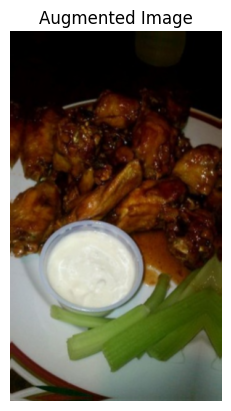

In [20]:
#Reading the random image 


# Read and plot in the random image 
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
augmented_img = tf.squeeze(augmented_img)

plt.imshow(augmented_img.numpy())
plt.axis(False)
plt.title("Augmented Image")
plt.show()
# print(augmented_img)

Original Image Min/Max: 0 255
Augmented Image Min/Max: 0.0 0.9715516


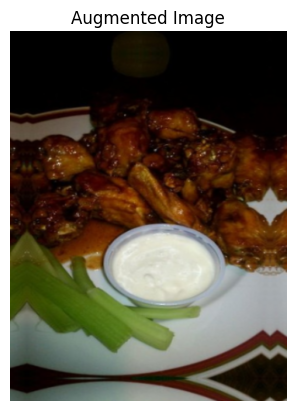

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

# Load the image
img = mpimg.imread(random_image_path)

# Ensure the image values are between 0 and 1
print("Original Image Min/Max:", img.min(), img.max())

# Apply augmentation
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
augmented_img = tf.squeeze(augmented_img)

# Ensure the augmented image has valid values
print("Augmented Image Min/Max:", augmented_img.numpy().min(), augmented_img.numpy().max())

# Display the image
plt.imshow(augmented_img.numpy())
plt.axis(False)
plt.title("Augmented Image")
plt.show()


In [22]:
# Fabricating model_1 : Feature Extraction Transfer Learning , on 1% of the data augmentation
from tf_keras import layers

# Freezing , base model layers 
input_shape = (224, 224, 3)
inputs = layers.Input(shape=input_shape, name="input_layer")
base_model = tf_keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape)
base_model.trainable = False  # The model is already pre-trained on ImageNet

# Adding the data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base model the input after they have been augmented, and not train it
x = base_model(x, training=False)

# Pool the output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer as an output
output = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = tf_keras.Model(inputs, output)

# Compile the model
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 10,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                # track the model training logs
                                callbacks = [create_tensorboard_callback (dir_name = "tensorflow_hub",
                                                                          experiment_name = "1_percent_data_aug")])

Saving TensorBoard log files to: tensorflow_hub/1_percent_data_aug/20250215-175309
Epoch 1/10
3/3 [==============================] - 9s 1s/step - loss: 2.3637 - accuracy: 0.1000 - val_loss: 2.3080 - val_accuracy: 0.1234
Epoch 2/10
3/3 [==============================] - 1s 661ms/step - loss: 2.3261 - accuracy: 0.1000 - val_loss: 2.3248 - val_accuracy: 0.0888
Epoch 3/10
3/3 [==============================] - 1s 643ms/step - loss: 2.3234 - accuracy: 0.1000 - val_loss: 2.3239 - val_accuracy: 0.0839
Epoch 4/10
3/3 [==============================] - 1s 642ms/step - loss: 2.3270 - accuracy: 0.1000 - val_loss: 2.3081 - val_accuracy: 0.1102
Epoch 5/10
3/3 [==============================] - 1s 646ms/step - loss: 2.3516 - accuracy: 0.0571 - val_loss: 2.3138 - val_accuracy: 0.1217
Epoch 6/10
3/3 [==============================] - 1s 625ms/step - loss: 2.3332 - accuracy: 0.1000 - val_loss: 2.3098 - val_accuracy: 0.1020
Epoch 7/10
3/3 [==============================] - 1s 630ms/step - loss: 2.3410 -

In [23]:
# Evaluating on the full test dataset

results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug


79/79 [==============================] - 5s 58ms/step - loss: 2.3334 - accuracy: 0.1000


[2.3334245681762695, 0.10000000149011612]

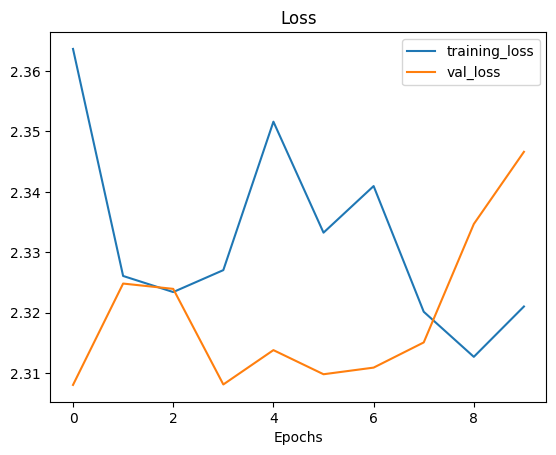

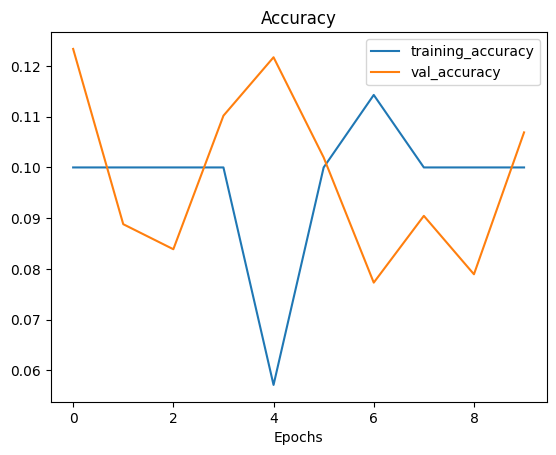

In [24]:
# Data augmentation loss curcees , with 1 % data , with augmentaion 

plot_loss_curves(history_1_percent)


# Model - 2 Feature Extraction transfer learing model , with 10% data , and data augmentation 

In [25]:
train_dir_10_percent = "10_food_classes_10_percent/10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/10_food_classes_10_percent/test"

In [26]:
# Crewate a data loaders : Make global variables 



train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [27]:
# Model_2 : data augmentation built in 


from tf_keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name = "data_augmentation")

#

imput_shape = (224, 224, 3)

#Create a base model 

base_model_2 = tf_keras.applications.EfficientNetB0(include_top=False)
base_model_2.trainable =False


inputs = layers.Input(shape = input_shape , name = "input_layer" )
x = data_augmentation(inputs) # Augmentation our training images 
x = base_model_2(x , training = False ) #freezes the layers in the model , also the batch_norm (BATCH NORMALIZATION)layers , are not updated
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_2")(x)
outputs = layers.Dense(10 , activation = "softmax", name = "output_layer")(x)
model_2 = tf_keras.Model(inputs , outputs)

#Compile 

model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf_keras.optimizers.Adam(),
                metrics=["accuracy"])





In [28]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_2 (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

### Creating a Model Checkpoint 

- Intermidiately saves our model ( the full model , or just the weights) during the training. Useful for resuming from any point 

In [29]:
#Set checkpoint path 

checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

#Creating a model checkpoit callback to save weights only

checkpoint_callback = tf_keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = True,
                                                         save_freq= "epoch" ,
                                                         verbose = 1)


In [30]:
## fit model_2 passing the model _callback checkpoint

initial_epochs = 5

history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = initial_epochs,
                                          validation_data = test_data,
                                          validation_steps = int(0.25 * len(test_data)),
                                          callbacks= [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                                  experiment_name = "10_percent_data_aug"),
                                                                                  checkpoint_callback])

Saving TensorBoard log files to: tensorflow_hub/10_percent_data_aug/20250215-175340
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0172 - accuracy: 0.3213
Epoch 1: val_loss improved from inf to 1.47286, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 311ms/step - loss: 2.0172 - accuracy: 0.3213 - val_loss: 1.4729 - val_accuracy: 0.6595
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3321 - accuracy: 0.6627
Epoch 2: val_loss improved from 1.47286 to 1.00219, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 4s 189ms/step - loss: 1.3321 - accuracy: 0.6627 - val_loss: 1.0022 - val_accuracy: 0.8026
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0028 - accuracy: 0.7627
Epoch 3: val_loss improved from 1.00219 to 0.79796, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [=====

In [31]:
#Check model_2 results on all test data 

results_10_percent_data_aug = model_2.evaluate(test_data)


79/79 [==============================] - 5s 57ms/step - loss: 0.6230 - accuracy: 0.8484


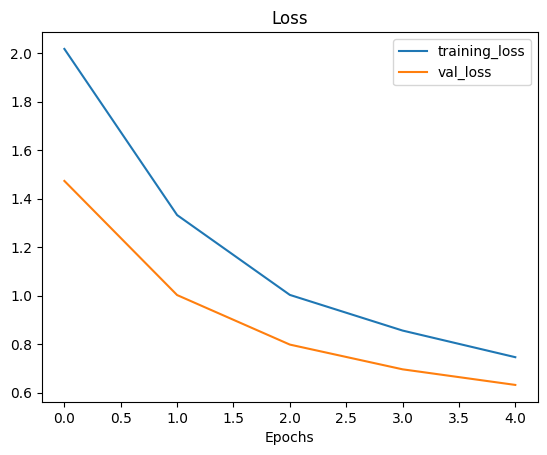

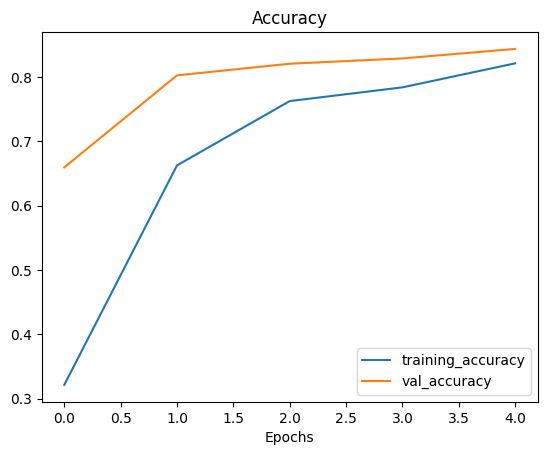

In [32]:
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights 

- Returns a Modelto a specific checkpoint.
- Results in the Loading weights should give same results in the existing weights 



In [33]:
# Load in saved model weights and evaluate 

model_2.load_weights(checkpoint_path)

In [34]:
# Evaluate model_2 with loaded weights 

loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 5s 58ms/step - loss: 0.6230 - accuracy: 0.8484


### If the results from the loaded weights , match the results from the trained model , then its working fine , this will not be the same as because of the machine memory for storing the numbers will be slightly fluctuated.

#### Computer Precision


In [35]:
results_10_percent_data_aug == loaded_weights_model_results

False

### Ignoring the Precison and Checking for Close Values 

In [36]:
# Check to see if loaded model results are close to non loaded results 

import numpy as np 

np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

### Model_3 : Fine-Tuning ,an existing model , on 10% of the data 



In [37]:
model_2.layers

In [38]:
# Check for the trainability of layers :

for layer in model_2.layers:
    print(layer, layer.trainable)

<tf_keras.src.engine.input_layer.InputLayer object at 0x776e13d5ba70> True
<tf_keras.src.engine.sequential.Sequential object at 0x776e10573aa0> True
<tf_keras.src.engine.functional.Functional object at 0x776e1cd41d00> False
<tf_keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x776e33b0af00> True
<tf_keras.src.layers.core.dense.Dense object at 0x776e30985dc0> True


In [39]:
# Check for the trainable layers in EfficientNetB0
for i , layers in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 output_layer True
1 output_layer True
2 output_layer True
3 output_layer True
4 output_layer True
5 output_layer True
6 output_layer True
7 output_layer True
8 output_layer True
9 output_layer True
10 output_layer True
11 output_layer True
12 output_layer True
13 output_layer True
14 output_layer True
15 output_layer True
16 output_layer True
17 output_layer True
18 output_layer True
19 output_layer True
20 output_layer True
21 output_layer True
22 output_layer True
23 output_layer True
24 output_layer True
25 output_layer True
26 output_layer True
27 output_layer True
28 output_layer True
29 output_layer True
30 output_layer True
31 output_layer True
32 output_layer True
33 output_layer True
34 output_layer True
35 output_layer True
36 output_layer True
37 output_layer True
38 output_layer True
39 output_layer True
40 output_layer True
41 output_layer True
42 output_layer True
43 output_layer True
44 output_layer True
45 output_layer True
46 output_layer True
47 output_layer True
48

In [40]:

# How many trainable variables in the Base_Model 
print(len(model_2.layers[2].trainable_variables))


0


In [ ]:
# Fine-Tuning  : Setting the last 10 layers in the base model = Trainable 

base_model.trainable = True 


# Freeze all layers except for the last 10 
for layers in base_model.layers[:-10]:
    layer.trainable = False

# Recompile the model 

model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf_keras.optimizers.Adam(learning_rate = 0.0001),
                metrics = ["accuracy"])



# When Fine-Tuning, lower the learning Rate by x 10
# Fine tune for another 5 epochs 

fine_tune_epochs = initial_epochs +5

# Refit the model (same as model_2 except with some more trainable layer)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.25 * len(test_data)),
                                               initial_epoch = history_10_percent_data_aug.epoch[-1] , # start training from previous last epoch
                                               callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                        experiment_name = "10_percent_fine_tune_last_10")])



Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20250215-175422
Epoch 5/10
24/24 [==============================] - 14s 275ms/step - loss: 0.6877 - accuracy: 0.8280 - val_loss: 0.6611 - val_accuracy: 0.8306
Epoch 6/10
24/24 [==============================] - 5s 196ms/step - loss: 0.6918 - accuracy: 0.8240 - val_loss: 0.6345 - val_accuracy: 0.8470
Epoch 7/10
24/24 [==============================] - 4s 181ms/step - loss: 0.6874 - accuracy: 0.8280 - val_loss: 0.6378 - val_accuracy: 0.8438
Epoch 8/10
24/24 [==============================] - 4s 181ms/step - loss: 0.6871 - accuracy: 0.8333 - val_loss: 0.6293 - val_accuracy: 0.8438
Epoch 9/10
24/24 [==============================] - 5s 189ms/step - loss: 0.6832 - accuracy: 0.8280 - val_loss: 0.6222 - val_accuracy: 0.8405
Epoch 10/10
24/24 [==============================] - 4s 180ms/step - loss: 0.7152 - accuracy: 0.8067 - val_loss: 0.6469 - val_accuracy: 0.8372


In [43]:
# Evaluate thr fine tuned model 

results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 5s 61ms/step - loss: 0.6230 - accuracy: 0.8484


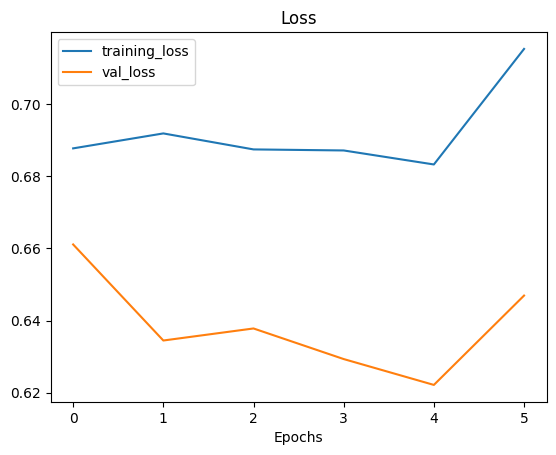

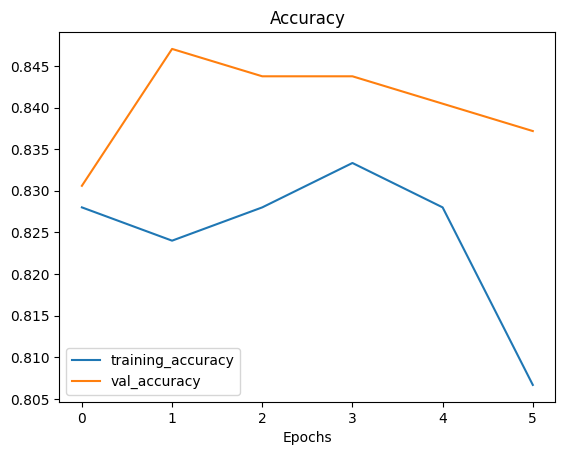

In [44]:
# Compare the histories and plotting loss curves 

plot_loss_curves(history_fine_10_percent_data_aug)



In [45]:
# Function to compare histories 

def compare_historys(original_history, new_history, initial_epochs =5) :
    #Get Original history measurements 
    acc= original_history["accuracy"]
    loss= original_history["loss"]

    val_acc  = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history 

    total_acc = acc + new_history.history["accuracy"]
    total_loss = acc + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots 

    plt.figuree(figsize=(8,8))
    plt.subplot(2 ,2 ,1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label = "Val Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label= "Start Fine Tunig")
    plt.legend(loc = "lower right" )
    plt.title("Training and Validation Accuracy")
    


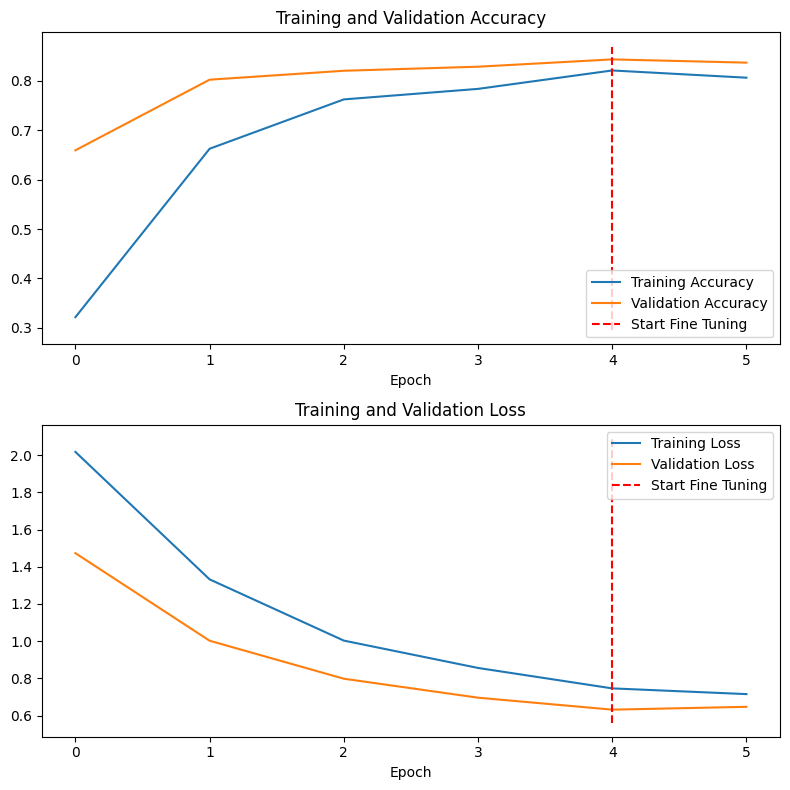

In [48]:
compare_historys(history_10_percent_data_aug,
                 history_fine_10_percent_data_aug,
                 initial_epochs = 5)

In [47]:
import matplotlib.pyplot as plt

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares the training history of two models (original and fine-tuned).

    Args:
        original_history: The history object of the original model.
        new_history: The history object of the fine-tuned model.
        initial_epochs: The number of epochs the original model was trained for.
    """

    # Get original history measurements (using .history)
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Get new history measurements (from initial_epochs onwards)
    new_acc = new_history.history["accuracy"][initial_epochs:]  # Slice!
    new_loss = new_history.history["loss"][initial_epochs:]      # Slice!
    new_val_acc = new_history.history["val_accuracy"][initial_epochs:] # Slice!
    new_val_loss = new_history.history["val_loss"][initial_epochs:] # Slice!

    # Combine the histories
    total_acc = acc + new_acc
    total_loss = loss + new_loss
    total_val_acc = val_acc + new_val_acc
    total_val_loss = val_loss + new_val_loss

    # Make plots
    plt.figure(figsize=(8, 8))  # Corrected figure size
    plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Validation Accuracy")
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning", linestyle="--", color="red") # Added styling
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch") # Added x-axis label

    plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Validation Loss")
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning", linestyle="--", color="red") # Added styling
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch") # Added x-axis label

    plt.tight_layout() # Adjusts subplot params for a tight layout
    plt.show()